# Bagging and Boosting (Question 1)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importing Libraries

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from random import randrange
from sklearn.model_selection import train_test_split as tts,GridSearchCV,cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor as dt
from sklearn.metrics import accuracy_score,confusion_matrix,mean_squared_error,make_scorer,f1_score,r2_score,mean_absolute_error

Loading Data (Housing Prices)

In [ ]:
housing=pd.read_csv('/content/drive/MyDrive/Data_PRML/Housing.csv')

Preprocessing

In [ ]:
#Encoding the categorical colummns(From scratch)

cat_feature=list(housing.select_dtypes(include=['object']).columns)
for feature in cat_feature:
    feature_value=list(housing[feature].unique())
    for val in feature_value:
        housing.loc[housing[feature]==val,feature]=feature_value.index(val)
housing.head()        

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,0,0,0,0,0,2,0,0
1,12250000,8960,4,4,4,0,0,0,0,0,3,1,0
2,12250000,9960,3,2,2,0,0,1,0,1,2,0,1
3,12215000,7500,4,2,2,0,0,1,0,0,3,0,0
4,11410000,7420,4,1,2,0,1,1,0,0,2,1,0


R2 score

In [ ]:
def R2_score(y_pred,y_test):
  Mean=y_test.mean()
  E1=0
  for i in range(len(y_pred)):
    E1=E1+(y_pred[i]-y_test[i])**2
  E2=0
  for i in y_pred:
    E2=E2+(i-Mean)**2
  return 1-(E1/E2)   

Deviding the dataset into Test and training subset

In [ ]:
user_prompt = 0.3
user_enable = True
Y=housing['price']
X=housing[['area','bedrooms','bathrooms','stories','mainroad','guestroom','basement','hotwaterheating','airconditioning','parking','prefarea','furnishingstatus']]
X_train,X_test,y_train,y_test = tts(X,Y,test_size=user_prompt,shuffle=user_enable)

Decision Tree Regressor

In [ ]:
mode=dt(max_depth=3)
mode.fit(X_train,y_train)
y_prif=mode.predict(X_test)
print("The r2 score for a single decision tree:",r2_score(y_test,y_prif))

The r2 score for a single decision tree: 0.39136676927216585


Five fold cross validation

In [ ]:
def splitting_into_kfold(x,y,n_fold):
  final=[]
  prefinal=[]
  Length_of_fold=round(x.shape[0]/n_fold)
  x_copy=x
  y_copy=y
  for i in range(n_fold):
    fold=[]
    told=[]
    while(len(fold)<Length_of_fold):
      r=randrange(x_copy.shape[0])
      index = x_copy.index[r]
      fold.append(x_copy.loc[index].tolist())
      told.append(y_copy.loc[index].tolist())
      x_copy = x_copy.drop(index)
      y_copy = y_copy.drop(index)
    final.append(np.asarray(fold))
    prefinal.append(np.array(told))
  return final,prefinal

def Cross_val_score(model,x,y,n):
  data_x,data_y=splitting_into_kfold(x,y,n)
  result=[]
  for i in range(n):
      r = list(range(n))
      test=data_x[i]
      r.pop(i)
      for j in r :  
          if j == r[0]:
              cv_1 = data_x[j]
              cv_2=data_y[j]
          else:    
              cv_1=np.concatenate((cv_1,data_x[j]), axis=0)
              cv_2=np.concatenate((cv_2,data_y[j]), axis=0)

      moel.fit(cv_1,cv_2)
      prediction=moel.predict(test)
      result.append(r2_score(prediction,data_y[i]))
  return np.asarray(result)       

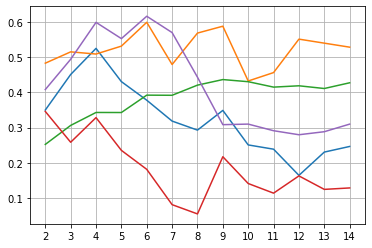

In [ ]:
data_x,data_y=splitting_into_kfold(X_train,y_train,5)
result=[]
L=[]
for i in range(5):
    r = list(range(5))
    test_x=data_x[i]
    test_y=data_y[i]
    r.pop(i)
    for j in r :
        if j == r[0]:
          cv_1 = data_x[j]
          cv_2=data_y[j]
        else:    
          cv_1=np.concatenate((cv_1,data_x[j]), axis=0)
          cv_2=np.concatenate((cv_2,data_y[j]), axis=0)
    for j in range(2,15,1):
      moel=dt(max_depth=j)                      
      moel.fit(cv_1,cv_2)
      prediction=moel.predict(test_x)
      L.append(r2_score(test_y,prediction))
      #result.append(r2_score(data_y[i],prediction))

    op=[i for i in range(2,15,1)]
    plt.plot(op,L)
    plt.xticks(op)
    plt.grid()
    L=[]  

Bagging

In [ ]:
class Bagger_decision_tree:

  def __init__(self,n_estimators):
    self.trees=n_estimators

  def Fit(self,depth,x,y,xtest,ytest):
    self.models=[]
    for i in range(self.trees):
      index=np.random.choice(x.shape[0],size=x.shape[0])
      X_1_train=x.iloc[index]
      Y_1_train=y.iloc[index]  
      model=dt(max_depth=depth)
      model.fit(X_1_train,Y_1_train)
      self.models.append(model)
      W=[]
      for j in range(2,15,1):
        h=dt(max_depth=j)
        h.fit(X_1_train,Y_1_train)
        P=h.predict(xtest)
        W.append(r2_score(ytest,P))
      print("the accuracy is:",W[1])  
      plt.figure(figsize=(8,4))  
      plt.plot([k for k in range(2,15,1)],W)
      plt.xticks([k for k in range(2,15,1)])
      plt.grid()
      plt.xlabel('Depth',fontsize=14)
      plt.ylabel('r2',fontsize=14)
      plt.show()

  def Predict(self,x):
    pred=np.zeros(x.shape[0]) 
    for model in self.models:
       
      pred=pred+(model.predict(x))
        
    return np.round((pred)/self.trees)  

  def acc(self,x,y_true,y_pred):
    return r2_score(y_true,y_pred)    

the accuracy is: 0.3395982937595011


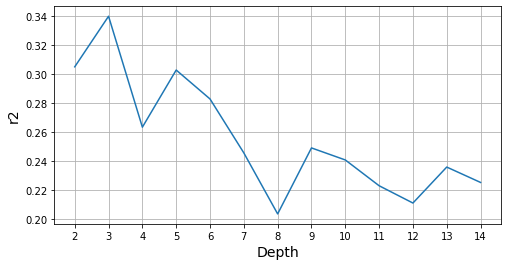

the accuracy is: 0.3506589187825945


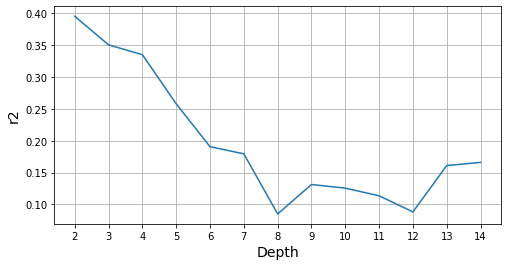

the accuracy is: 0.1998565374834087


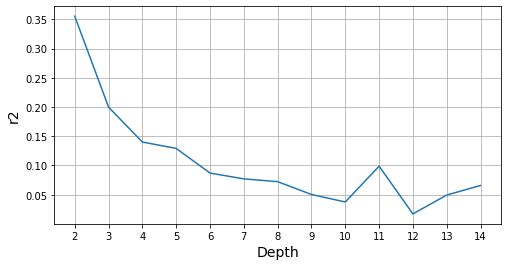

the accuracy is: 0.3220022068360966


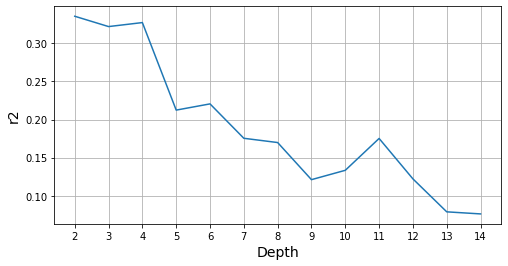

the accuracy is: 0.35769495696009035


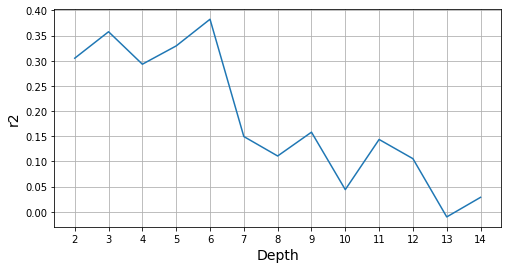

the accuracy is: 0.39319134199784134


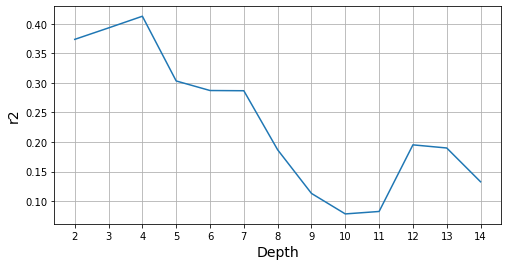

the accuracy is: 0.31368436181255566


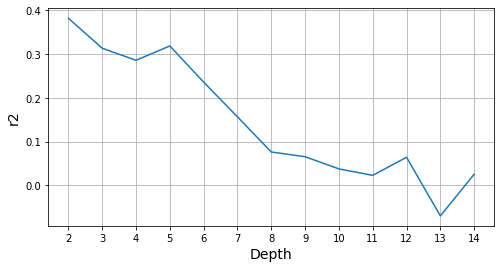

the accuracy is: 0.3195479762721788


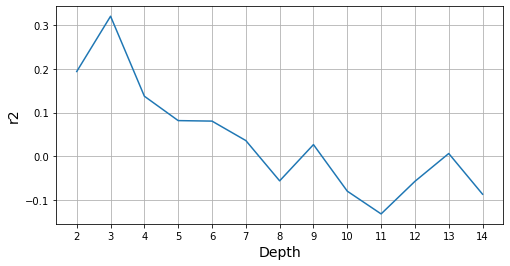

the accuracy is: 0.1657289918966126


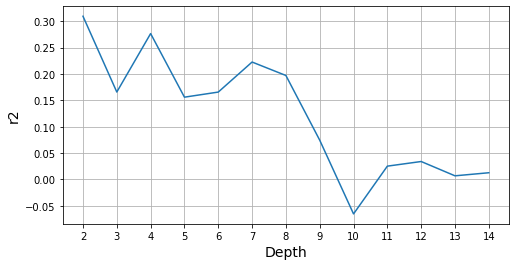

the accuracy is: 0.3303411259861314


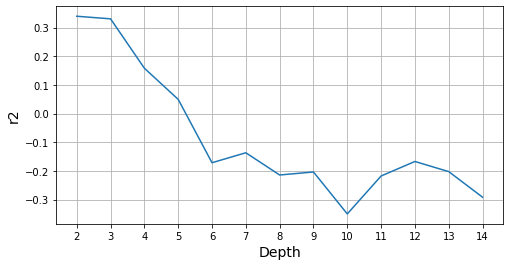

The r2 score for our bagger decision tree is: 0.4901142812715388


In [ ]:
my_tree=Bagger_decision_tree(10)
my_tree.Fit(3,X_train,y_train,X_test,y_test)
y_pred=my_tree.Predict(X_test)
L=y_test.to_numpy()
print("The r2 score for our bagger decision tree is:",my_tree.acc(X_test,L,y_pred))

Plot for increase and decrease in the depth of the Bagging Tree

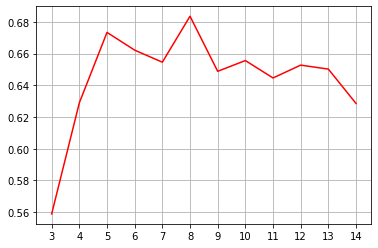

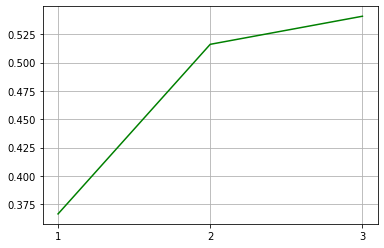

In [ ]:
depth=[i for i in range(3,15,1)]
w=[]
for i in depth:
  fict=Bagger_decision_tree(10)
  fict.Fit(i,X_train,y_train,X_test,y_test)
  w.append(r2_score(y_test,fict.Predict(X_test)))

plt.plot(depth,w,'r')
plt.xticks(depth)
plt.grid()
plt.show()


depth=[i for i in range(1,4,1)]
w=[]
for i in depth:
  fict=Bagger_decision_tree(10)
  fict.Fit(i,X_train,y_train,X_test,y_test)
  w.append(r2_score(y_test,fict.Predict(X_test)))
plt.plot(depth,w,'g')
plt.xticks(depth)
plt.grid()
plt.show()


Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor as RF
Ti=RF(n_estimators = 10, random_state = 0)
Ti.fit(X_train,y_train)
y_op=Ti.predict(X_test)
print("The mean squared error is:",mean_squared_error(L,y_op))
print("The absolute error is:",mean_absolute_error(L,y_op))
print("The r2 score is:",r2_score(L,y_op))


The mean squared error is: 1456894790118.4111
The absolute error is: 875061.392276423
The r2 score is: 0.5110239339670194


AdaBoost Regressor

In [ ]:
from sklearn.ensemble import AdaBoostRegressor as FT
Ti=FT(n_estimators = 10, random_state = 0)
Ti.fit(X_train,y_train)
y_op=Ti.predict(X_test)
print("The mean squared error is:",mean_squared_error(L,y_op))
print("The absolute error is:",mean_absolute_error(L,y_op))
print("The r2 score is:",r2_score(L,y_op))

The mean squared error is: 1579385940670.4639
The absolute error is: 918485.8681700148
The r2 score is: 0.46991235794447883


# Boosting (Question 2)

Importing necessary libraries

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from random import randrange
from sklearn.model_selection import train_test_split as tts,GridSearchCV,cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor as dt
from sklearn.tree import DecisionTreeClassifier as Dt
from sklearn.metrics import accuracy_score,confusion_matrix,mean_squared_error,make_scorer,f1_score,r2_score,mean_absolute_error

Loading the data

In [ ]:
cancer=pd.read_csv('/content/drive/MyDrive/Data_PRML/Breast_cancer_data.csv')

Getting information about the dataset

In [ ]:
cancer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   mean_radius      569 non-null    float64
 1   mean_texture     569 non-null    float64
 2   mean_perimeter   569 non-null    float64
 3   mean_area        569 non-null    float64
 4   mean_smoothness  569 non-null    float64
 5   diagnosis        569 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 26.8 KB


Visualiization of the dataset

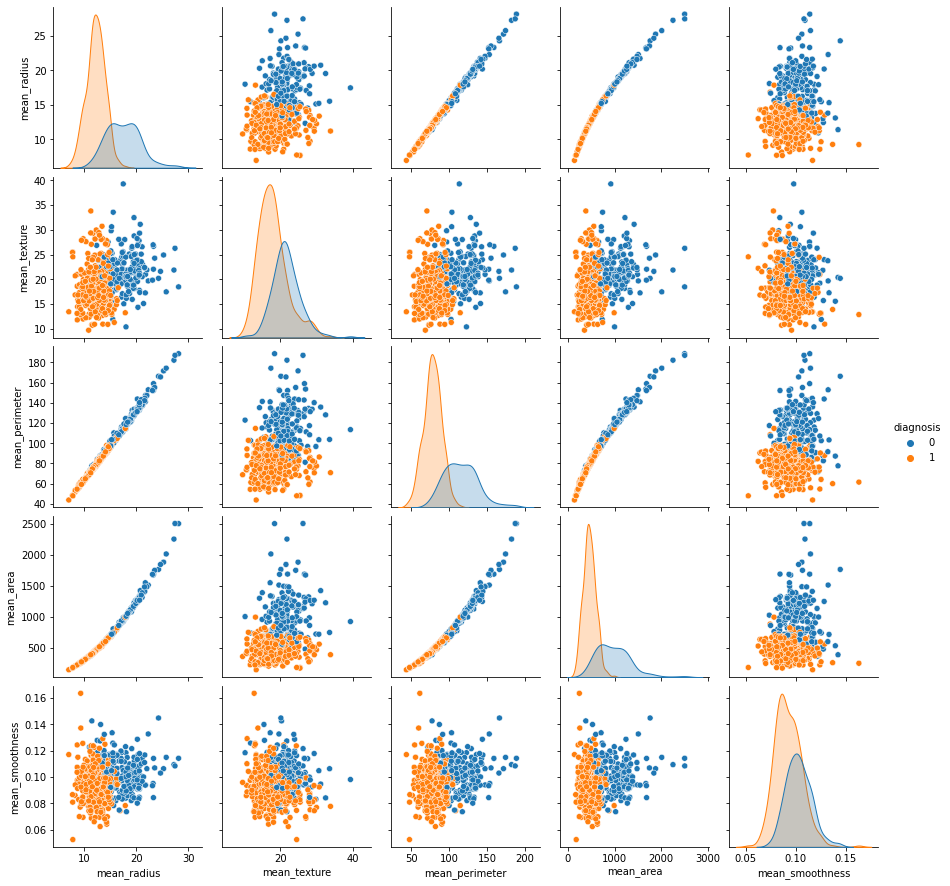

In [ ]:
sns.pairplot(cancer, hue='diagnosis')

Decision Tree Classifier

In [ ]:
class Node:
  def __init__(self,dataset,left_branch,right_branch,Best_feature):
    self.predictions=dataset['diagnosis'].value_counts().nlargest(1)
    self.left=left_branch
    self.right=right_branch
    self.feature=Best_feature

def gini_index(dataset,threshold,feature):
  main_values=dataset['diagnosis'].unique()
  left_df=dataset[dataset[feature]<=threshold]
  right_df=dataset[dataset[feature]>threshold]
  a=0
  b=0
  for val in main_values:
    a+=(left_df[left_df['diagnosis']==val].shape[0]/left_df.shape[0])**2
  a=1-a
  for val in main_values:
    b+=(right_df[right_df['diagnosis']==val].shape[0]/right_df.shape[0])**2
  b=1-b
  g=(((left_df.shape[0])/dataset.shape[0])*a)+(((right_df.shape[0])/dataset.shape[0])*b) 
  return g     

def cont_to_cat(dataset,feature):
  Min=dataset[feature].min()
  Max=dataset[feature].max()
  List=list(np.arange(Min,Max,1))
  G=1
  threshold=None
  for val in List:
    g=gini_index(dataset,val,feature)
    if(G>g):
      G=g
      threshold=val
  dataset.loc[dataset[feature]<=threshold,feature]=0
  dataset.loc[dataset[feature]>threshold,feature]=1    
  
  return G    

def get_feature(dataset):
  best=None
  gini=1
  features=['mean_radius','mean_texture','mean_perimeter','mean_area','mean_smoothness']
  for feature in features:
    b=cont_to_cat(dataset,feature)
    if(gini>b):
      gini=b
      best=feature
  return gini,best    

def build_tree(dataset,max_depth):
  if(max_depth==0):
    return Node(dataset,None,None,None)
  elif(len(dataset)==0):
    return None
  else:
    gini,best_feature=get_feature(dataset)
    if(best_feature!=None):
      left_df=dataset[dataset[best_feature]==0]
      right_df=dataset[dataset[best_feature]==1]
      left_branch=build_tree(left_df,max_depth-1)
      right_branch=build_tree(right_df,max_depth-1)
      return Node(dataset,left_branch,right_branch,best_feature)
    else:
      return Node(dataset,None,None,None)  

def classify(row, node):
    if(node.left==None or node.right==None):
      return node.predictions 
    elif(row[node.feature]==0):
      return classify(row,node.left)
    elif(row[node.feature]==1):
      return classify(row,node.right)
           

Splitting the dataset into training and testing data

In [ ]:
user_prompt = 0.3
user_enable = True
Y=cancer['diagnosis']
X=cancer[['diagnosis','mean_radius','mean_texture','mean_perimeter','mean_area','mean_smoothness']]
x_train,x_test,y_train,y_test = tts(X,Y,test_size=user_prompt,shuffle=user_enable)

five fold cross validation

In [ ]:
def splitting_into_kfold(x,y,n_fold):
  final=[]
  prefinal=[]
  Length_of_fold=round(x.shape[0]/n_fold)-1
  x_copy=x
  y_copy=y
  for i in range(n_fold):
    fold=[]
    told=[]
    while(len(fold)<Length_of_fold):
      r=randrange(x_copy.shape[0])
      index = x_copy.index[r]
      fold.append(x_copy.loc[index].tolist())
      told.append(y_copy.loc[index].tolist())
      x_copy = x_copy.drop(index)
      y_copy = y_copy.drop(index)
    final.append(np.asarray(fold))
    prefinal.append(np.array(told))
  return final,prefinal

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a

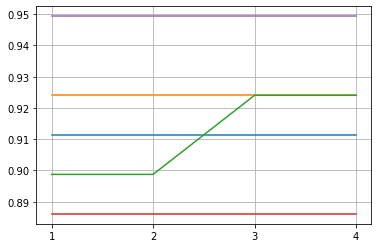

In [ ]:
data_x,data_y=splitting_into_kfold(x_train,y_train,5)
result=[]
L=[]
for i in range(5):
    cv_1=[]
    r = list(range(5))
    test=data_x[i]
    r.pop(i)
    for j in r :
        if j == r[0]:
          cv_1 = data_x[j]
        else:    
          cv_1=np.concatenate((cv_1,data_x[j]), axis=0)   
    df_ori=pd.DataFrame(cv_1)
    df_ori.columns=['diagnosis','mean_radius','mean_texture','mean_perimeter','mean_area','mean_smoothness']
    df_yori=pd.DataFrame(test)
    df_yori.columns=['diagnosis','mean_radius','mean_texture','mean_perimeter','mean_area','mean_smoothness']      
    for j in range(1,5,1):
      Xtrain=df_ori.copy()
      moel=build_tree(Xtrain,max_depth=j)                      
      pred=[]
      Xtest=df_yori.copy()
      for feature in ['mean_radius','mean_texture','mean_perimeter','mean_area','mean_smoothness']:
        cont_to_cat(Xtest,feature)
      for row in Xtest.iterrows():
        pred.append(int(float(str(classify(row[1],moel)).split()[0])))   
      L.append(accuracy_score(Xtest['diagnosis'],pred))

    op=[i for i in range(1,5,1)]
    plt.plot(op,L)
    plt.xticks(op)
    plt.grid()
    L=[]  

Accuracy of a single decision classifier

In [ ]:
my_tree=build_tree(x_train.copy(),4)
pred=[]
Xtest=x_test.copy()
for feature in ['mean_radius','mean_texture','mean_perimeter','mean_area','mean_smoothness']:
  cont_to_cat(Xtest,feature)
for row in Xtest.iterrows():
  pred.append(int(float(str(classify(row[1],my_tree)).split()[0])))   
print("The accuracy of my tree is:",accuracy_score(Xtest['diagnosis'],pred))

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


The accuracy of my tree is: 0.8830409356725146


XGBoost

In [ ]:
x=x_train[['mean_radius','mean_texture','mean_perimeter','mean_area','mean_smoothness']]
xT=x_test[['mean_radius','mean_texture','mean_perimeter','mean_area','mean_smoothness']]

In [ ]:
import xgboost as xgb
my_model = xgb.XGBClassifier(subsample=0.7 ,max_depth=3,)
my_model.fit(x, y_train)
y_pred = my_model.predict(xT)
accu = accuracy_score(y_test, y_pred)
print("accuracy (in test)is:",accu)

accuracy (in test)is: 0.9298245614035088


In [ ]:
my_model = xgb.XGBClassifier(subsample=0.7 ,max_depth=3,)
my_model.fit(x, y_train)
y_pred = my_model.predict(x)
accu = accuracy_score(y_train, y_pred)
print("accuracy (for train) is:",accu)

accuracy (for train) is: 0.9773869346733668


LGBM classifier

In [ ]:
from lightgbm import LGBMClassifier

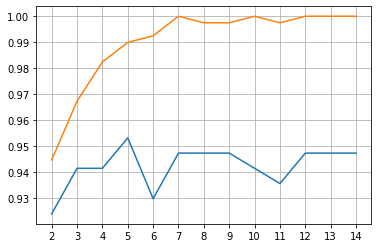

In [ ]:
L=[]
T=[]
for i in range(2,15,1):  
  model_1 = LGBMClassifier(max_depth=4,num_leaves=i)
  model_1.fit(x, y_train)
  pred = model_1.predict(xT)
  L.append((accuracy_score(y_test, pred)))

for i in range(2,15,1):  
  model_1 = LGBMClassifier(max_depth=4,num_leaves=i)
  model_1.fit(x, y_train)
  pred = model_1.predict(x)
  T.append((accuracy_score(y_train, pred)))


plt.plot([i for i in range(2,15,1)],L)
plt.plot([i for i in range(2,15,1)],T)
plt.xticks([i for i in range(2,15,1)])
plt.grid()  

print()